# Introduction
In this part of the project I would like to build a model that helps me visualize the book "An Inquiry" by Adam Smith.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 15, 10
plt.style.use("ggplot")
from nltk.corpus import stopwords

In [52]:
from utilityfuncs.econbooks import InquiryNatureCauseWealth
from utilityfuncs.utilityFunctions import clean_sent, word2vec_to_dataframe

I have put some information about the book that we can retrieve just using the class I defined.

In [3]:
cause_of_wealth = InquiryNatureCauseWealth()

In [4]:
cause_of_wealth.title

'An Inquiry into the Nature and Causes of the Wealth of Nations'

In [5]:
cause_of_wealth.author

'Adam Smith'

Now let's get the text for our analysis. It will query the Gutenberg site and process the HTML book to extract the books paragraphs.

In [6]:
cause_of_wealth_text = cause_of_wealth.get_text()

In [51]:
from pickle import dump
with open("wealth-of-nations/cause_of_wealth.sav", "wb") as f:
    dump(cause_of_wealth_text, f)

In [7]:
print(cause_of_wealth_text[2])


      But this proportion must in every nation be regulated by two different
      circumstances: first, by the skill, dexterity, and judgment with which its
      labour is generally applied; and, secondly, by the proportion between the
      number of those who are employed in useful labour, and that of those who
      are not so employed. Whatever be the soil, climate, or extent of territory
      of any particular nation, the abundance or scantiness of its annual supply
      must, in that particular situation, depend upon those two circumstances.
    


In [8]:
len(cause_of_wealth_text)

2089

There is a total of 2089 paragraphs in the Adam Smith's book. Before applying any Machine learning technique, we need to clean the text and make it suitable for analysis. We are going to tokenize the text, remove stopwords.

As we see through this example all the words are now distinct so we refer to them individually. However many tokens are useless for example the punctuations and words likes "the, or,is". We need to lower all the words and remove the punctuations and the stopwords.

In [9]:
stopwords.words("english")[10:15]

["you've", "you'll", "you'd", 'your', 'yours']

But before we remove them, we need to make sure all words are in lower case and that all punctuations are removes.

Now we can remove the stopwords

# What I want :
for each list in sentences:
- lower the list
- remove punctuation
- remove stopwords

In [10]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

def remove_stopwords(text, stopw = stopwords.words("english")):
    list_of_sentences = []
    
    for sentences in text:
        list_of_words = []
        for word in sentences:
            if not word in stopw:
                list_of_words.append(word)
        list_of_sentences.append(list_of_words)
    return list_of_sentences

def clean_sent(sentences):
    """Sentence must be a list containing string"""
    stopw = stopwords.words("english")
    # Lower each word in each sentence        
    sentences = [tokenizer.tokenize(sent.lower()) for sent in sentences]
    sentences = remove_stopwords(sentences)
    return sentences

In [11]:
sentences = clean_sent(cause_of_wealth_text)

In [12]:
print(sentences[2])

['proportion', 'must', 'every', 'nation', 'regulated', 'two', 'different', 'circumstances', 'first', 'skill', 'dexterity', 'judgment', 'labour', 'generally', 'applied', 'secondly', 'proportion', 'number', 'employed', 'useful', 'labour', 'employed', 'whatever', 'soil', 'climate', 'extent', 'territory', 'particular', 'nation', 'abundance', 'scantiness', 'annual', 'supply', 'must', 'particular', 'situation', 'depend', 'upon', 'two', 'circumstances']


# Word2vec model
From now we can build our model because the text is already cleaned

In [13]:
from gensim.models import word2vec

In [14]:
# We stick with the default paramaters. it will create 100 dimensional vector for each
# word
model = word2vec.Word2Vec(
    min_count = 20,
    size = 200,
    alpha= 0.03
)

In [15]:
model.build_vocab(sentences)

In [16]:
model.train(sentences, total_examples= model.corpus_count, epochs = 50)

(6671033, 9049600)

In [17]:
model.init_sims(replace= True)

In [45]:
model.wv.most_similar("wealth")

[('riches', 0.5619071125984192),
 ('prosperity', 0.4382431209087372),
 ('civilized', 0.37181204557418823),
 ('advancing', 0.36811450123786926),
 ('declining', 0.3663334250450134),
 ('declension', 0.3527595102787018),
 ('greatness', 0.3407771587371826),
 ('stationary', 0.33885812759399414),
 ('population', 0.31140103936195374),
 ('source', 0.30277693271636963)]

In [19]:
model.wv.most_similar("labour")

[('labourers', 0.44752126932144165),
 ('labourer', 0.43288102746009827),
 ('food', 0.409370481967926),
 ('industry', 0.36730319261550903),
 ('motion', 0.3587263226509094),
 ('quantity', 0.3505135774612427),
 ('tools', 0.3497554659843445),
 ('increases', 0.3377353250980377),
 ('rude', 0.3347717225551605),
 ('workmen', 0.32991641759872437)]

In [20]:
model.wv.most_similar("force")

[('military', 0.4601132869720459),
 ('discipline', 0.45804455876350403),
 ('subordination', 0.36972570419311523),
 ('civil', 0.349850058555603),
 ('authority', 0.3351767659187317),
 ('spirit', 0.33329829573631287),
 ('exercises', 0.31488150358200073),
 ('careful', 0.313335120677948),
 ('sovereign', 0.3083277642726898),
 ('violence', 0.30641883611679077)]

In [21]:
all_words = model.wv.vectors

In [22]:
from sklearn.manifold import TSNE

In [23]:
tsne = TSNE(n_components= 2, random_state= 1)

In [24]:
all_words_3dmatrix = tsne.fit_transform(all_words)

In [39]:
import pandas as pd
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_words_3dmatrix[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [26]:
points.head()

,word,x,y
0,annual,6.014619,25.994410
1,labour,2.606754,34.961040
2,every,26.974310,31.706059
3,nation,10.768867,50.394260
4,fund,-29.754848,2.967999


In [27]:
%matplotlib inline

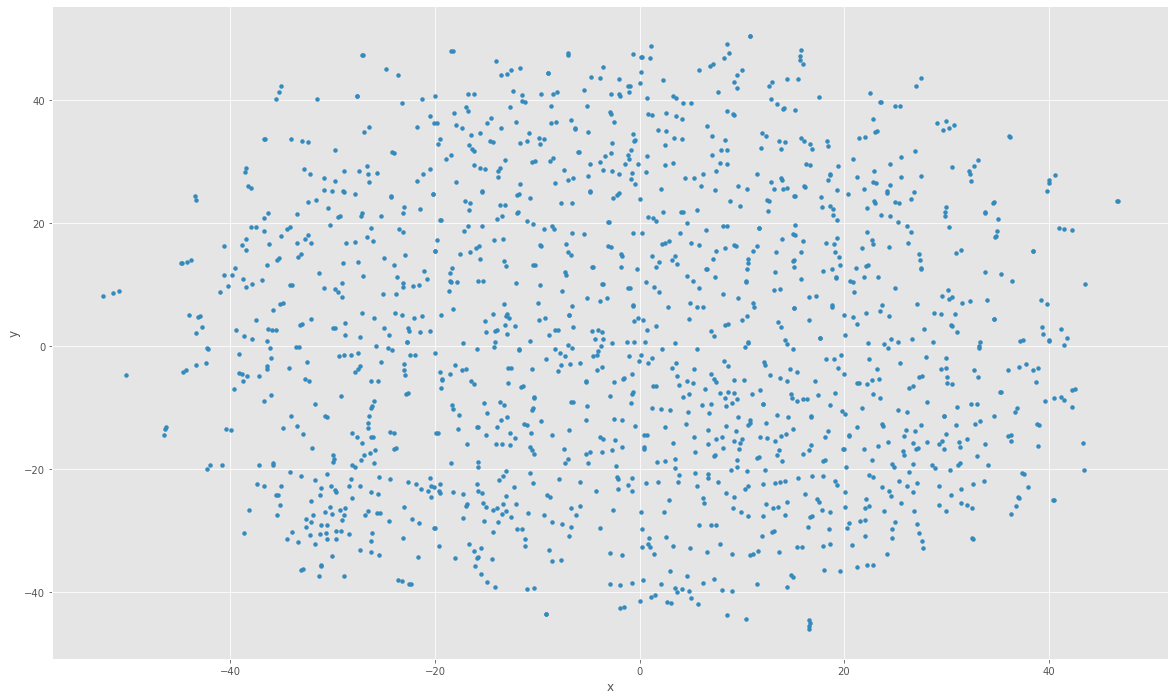

In [28]:
points.plot.scatter("x", "y", s=15, figsize=(20, 12));

In [37]:
import matplotlib.pyplot as plt
def plot_region(x_bounds, y_bounds):
    slices = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    print(slices.shape)
    ax = slices.plot.scatter("x", "y", s=35, figsize=(15, 10))
    for i, point in slices.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=8)

(58, 3)


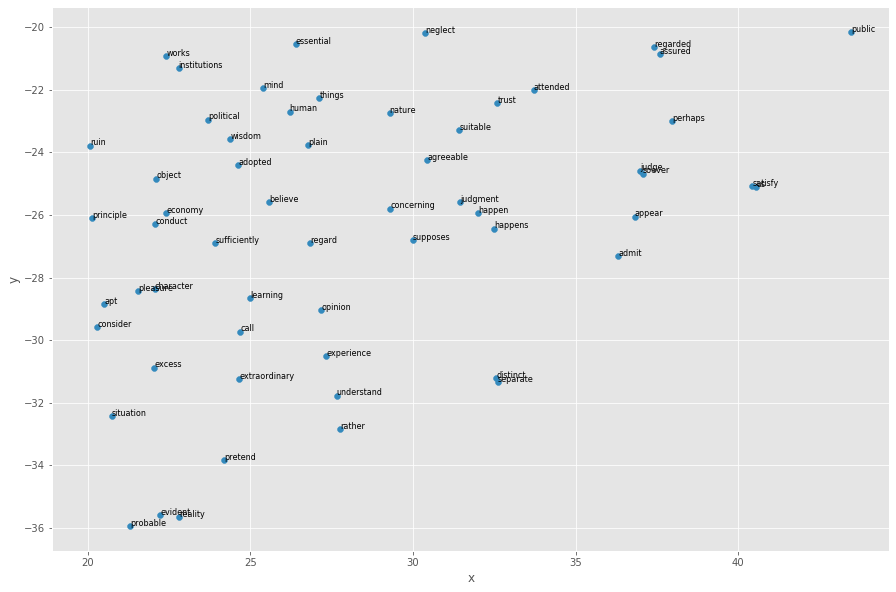

In [40]:
plot_region(x_bounds=(20, 60), y_bounds=(-40, -20))

(47, 3)


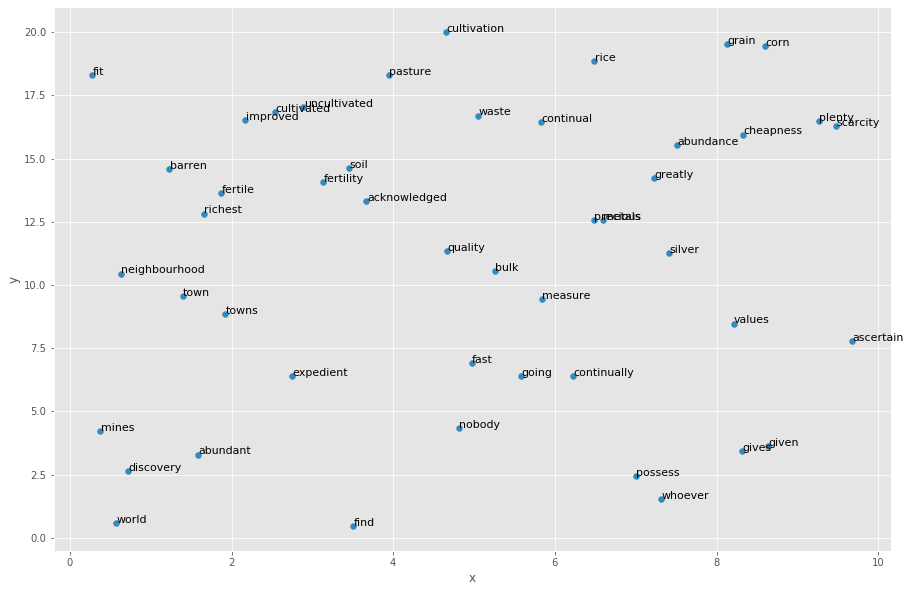

In [31]:
plot_region(x_bounds=(0, 10), y_bounds=(0, 20))

In [32]:
from sklearn.decomposition import PCA

In [33]:
pca = PCA(n_components= 2, random_state=1)
pca = pca.fit_transform(all_words)

In [34]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, pca[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)
points.head()

,word,x,y
0,annual,-0.262373,-0.159193
1,labour,-0.306682,-0.438928
2,every,0.032218,-0.164176
3,nation,0.198554,-0.116187
4,fund,-0.109304,-0.082831


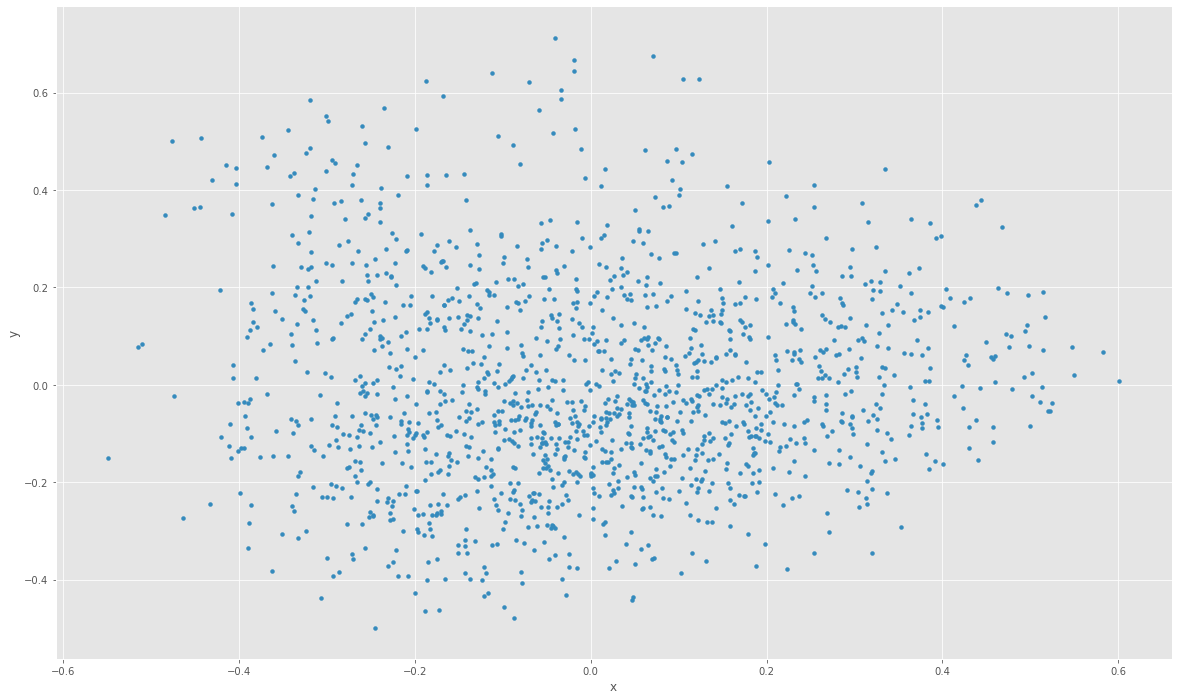

In [35]:
points.plot.scatter("x", "y", s=15, figsize=(20, 12))

(268, 3)


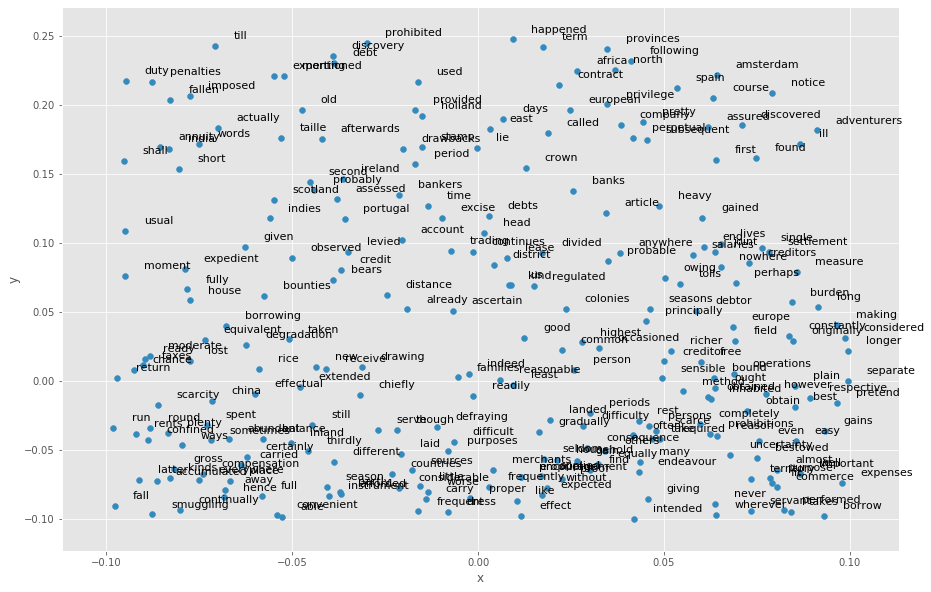

In [36]:
plot_region(x_bounds=(-0.1, 0.1), y_bounds=(-0.1, 0.25))

In [46]:
model.wv.most_similar("slave")

[('servant', 0.448158860206604),
 ('slaves', 0.4418288469314575),
 ('master', 0.4168241024017334),
 ('obtain', 0.4111442565917969),
 ('magistrate', 0.4010221064090729),
 ('tenants', 0.3830781579017639),
 ('retainers', 0.36385253071784973),
 ('service', 0.3322179913520813),
 ('principle', 0.32821768522262573),
 ('authority', 0.32431161403656006)]

In [41]:
# save the text and the model
import os
import pickle
#filename = 'tsne_model.sav'
#pickle.dump(all_words_vectors, open(filename, 'wb'))

In [42]:
os.mkdir("wealth-of-nations")

In [43]:
os.path.isdir("wealth-of-nations")

True